In [0]:
# import modules
import numpy as np
import pandas as pd
#import modin.pandas as pd # faster pandas
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

## Data Overview

In [0]:
# Import data from google drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
train = pd.read_csv("/content/drive/My Drive/School/Applied Data Science_GR5243/Project 5/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
#train = pd.read_csv("/Users/zeyu/Google Drive/School/Applied Data Science_GR5243/Project 5/jigsaw-unintended-bias-in-toxicity-classification/train.csv")

In [0]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [0]:
train.shape

(1804874, 45)

This dataset contains around 1.8 millions of observations and 45 columns.

## Proportion of toxic observations

(array([1.739093e+06, 1.388900e+04, 3.726400e+04, 8.031000e+03,
        5.926000e+03, 1.330000e+02, 4.210000e+02, 2.700000e+01,
        6.700000e+01, 6.000000e+00, 4.000000e+00, 8.000000e+00,
        1.000000e+00, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([0.        , 0.04545455, 0.09090909, 0.13636364, 0.18181818,
        0.22727273, 0.27272727, 0.31818182, 0.36363636, 0.40909091,
        0.45454545, 0.5       , 0.54545455, 0.59090909, 0.63636364,
        0.68181818, 0.72727273, 0.77272727, 0.81818182, 0.86363636,
        0.90909091, 0.95454545, 1.        ]),
 <a list of 22 Patch objects>)

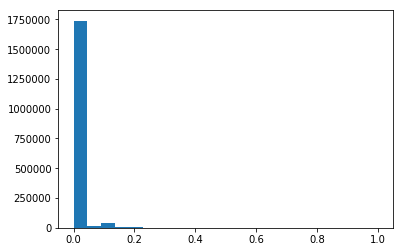

In [0]:
tmp = train["severe_toxicity"]
plt.hist(tmp, bins="auto")

This data is quite imbalanced. The majority of the observations are non-toxic.

In [0]:
tmp = [1 for i in train["severe_toxicity"] if i==0]

print("{:.0f}% of the data is not toxic.".format(len(tmp)/train.shape[0]*100))

94% of the data is not toxic.


## Number of characters in sentence

(-100, 1500)

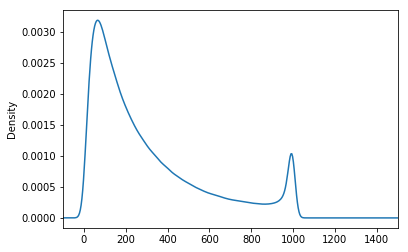

In [0]:
length = train["comment_text"].apply(len)
p = length.plot.kde()
p.set_xlim(-100,1500)

## Number of words in sentence

(-50, 250)

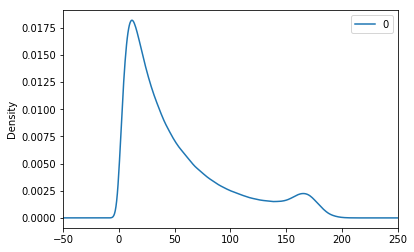

In [0]:
length = [len(i.split()) for i in train["comment_text"]]
length = pd.DataFrame(np.array(length))
p = length.plot.kde()
p.set_xlim(-50,250)

Most sentences consists around 0 to 50 words. However, there is also a small peak in 150 to 200 words.

In [0]:
index_long = (length > 150) & (length < 200)
index_long = index_long[0].tolist()

In [0]:
train["comment_text"][index_long].head()

96     Hi David, we did consider all of these possibi...
168    Good question, Jackie! How do these yokels mak...
198    Do not so readily suppose that people coming o...
200    To meet these people with threats of violence ...
211    Hi Jeff, you bring up interesting points.\n\n"...
Name: comment_text, dtype: object

These long sentences seem to come from some emails.

## Percentage of toxic comments among different identity groups

Percent of toxic comments related to different identities, using target and popolation amount of each identity as weights:

In [0]:
identity = pd.concat([train.loc[:,"target"],train.loc[:,"asian":"white"]],axis=1).dropna()

weighted_toxicity =identity.iloc[:,1:].multiply(identity.iloc[:,0],axis="index").sum()/identity.iloc[:,1:][identity.iloc[:,1:]>0].count()

weighted_toxicity = weighted_toxicity.sort_values(ascending=False).to_frame().reset_index()

weighted_toxicity.columns = ["identity","weighted_toxicity"]

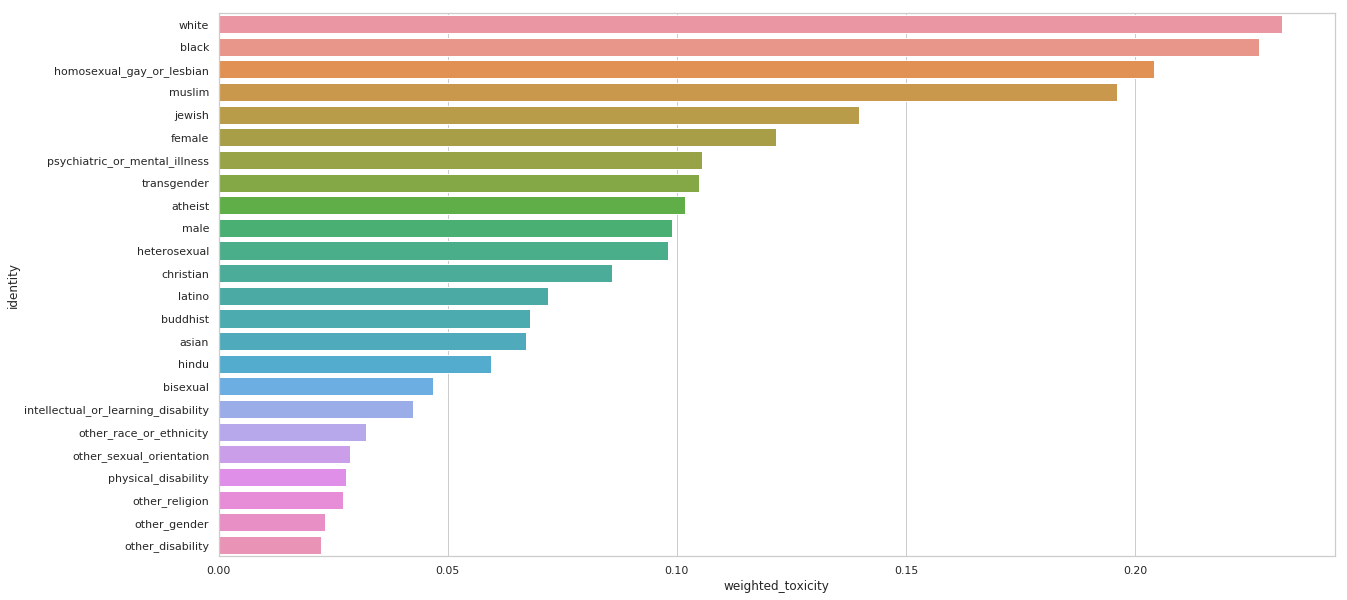

In [0]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
ax = sns.barplot(x="weighted_toxicity",y="identity", data=weighted_toxicity)

White, balck, and homosexual are the top three most mentioned identity groups.

## Corelation between comment labels and identity groups

In [0]:
identity = pd.concat([train.iloc[:,list(range(4,7))+list(range(37,42))],train.loc[:,"asian":"white"]],axis=1).dropna()

In [0]:
corr_matrix = identity.corr().iloc[8:,:8]

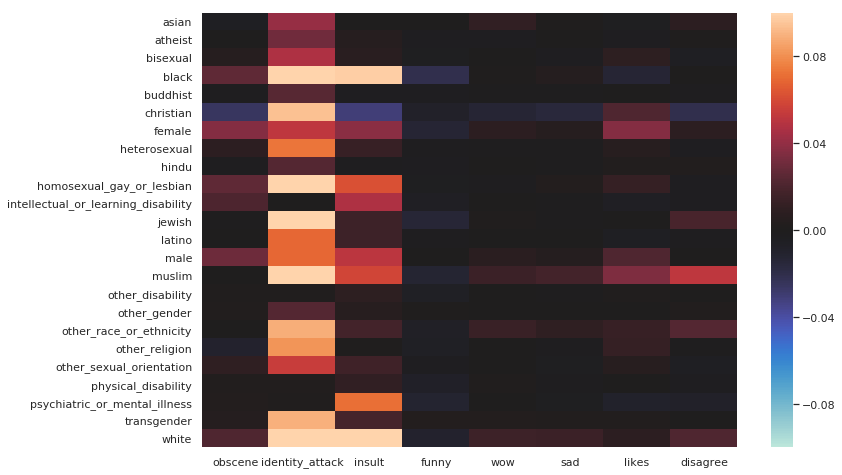

In [0]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(corr_matrix, vmin=-0.1, vmax=0.1, center=0.0)

## Time series plot

In [0]:
withdate = train.loc[:, ['created_date', 'target']+list(train)[slice(8,32)]].dropna()
raceweighted = withdate.iloc[:, 2:]/withdate.iloc[:, 2:].sum()
race_target_weighted = raceweighted.multiply(withdate.iloc[:, 1], axis="index")
race_target_weighted['created_date'] = pd.to_datetime(withdate['created_date']).values.astype('datetime64[M]')
weighted_demo = race_target_weighted.groupby(['created_date']).sum().sort_index()

### Toxicity & Race

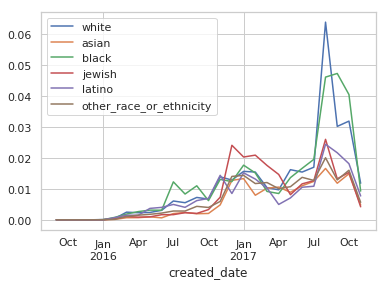

In [0]:
weighted_demo[['white', 'asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity']].plot.line()
plt.show()

### Toxicity & Religion

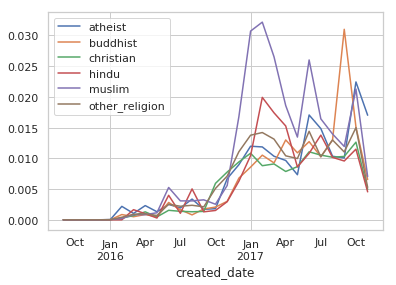

In [0]:
weighted_demo[['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion']].plot.line()
plt.show()

There is peak in Jan 2017 for Muslim. This may because on Friday, January 27, 2017
President Donald Trump signed an Executive Order that banned foreign nationals from seven predominantly Muslim countries from visiting the country for 90 days, suspended entry to the country of all Syrian refugees indefinitely, and prohibited any other refugees from coming into the country for 120 days.

### Toxicity & Sexual Orientation

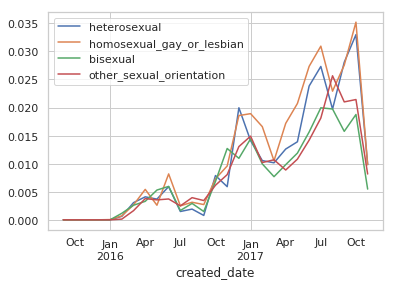

In [0]:
weighted_demo[['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']].plot.line()
plt.show()

### Toxicity & Gender

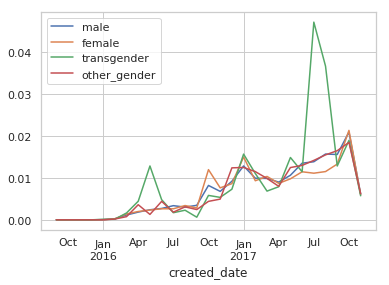

In [0]:
weighted_demo[['male', 'female', 'transgender', 'other_gender']].plot.line()
plt.show()

There is a peak in Jul 2017 for transgender. This may because President Trump abruptly announced a ban on transgender people serving in the military on Wednesday, blindsiding his defense secretary and Republican congressional leaders with a snap decision that reversed a year-old policy reviled by social conservatives.

### Toxicity & Disability

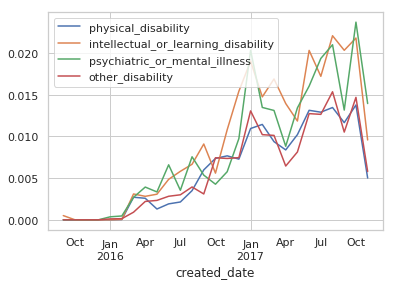

In [0]:
weighted_demo[['physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability']].plot.line()
plt.show()